# Calculate POP2 heat budget using xgcm

In this notebook, we are going to use xgcm with metrics to demonstrate budget closure for the 0.1 degree horizontal resolution version of POP2. Note that the lower resolution has more parameterizations and therefore does not close following this notebook. This notebook was contributed by [Anna-Lena Deppenmeier](https://github.com/ALDepp).


This is an image of the POP output structure on the horizontal B-grid courtesy of [Yassir Eddebbar](https://github.com/Eddebbar).

<img src="POP_Grid.png" alt="Drawing" style="width: 800px;"/>

## Import packages and define functions

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

import pop_tools


def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()


def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[152, :].values - value))

## Load Dataset

In [2]:
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch("Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc")
ds_g = xr.open_dataset(filepath_g)

In [3]:
ds

<xarray.Dataset>
Dimensions:         (nlat: 305, nlon: 1301, time: 1, z_t: 62, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time            (time) object 0036-12-07 00:00:00
  * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG           (nlat, nlon) float64 ...
    ULAT            (nlat, nlon) float64 ...
    TLONG           (nlat, nlon) float64 ...
    TLAT            (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables: (12/26)
    TEND_TEMP       (time, z_t, nlat, nlon) float32 ...
    UET             (time, z_t, nlat, nlon) float32 ...
    VNT             (time, z_t, nlat, nlon) float32 ...
    WTT             (time, z_w_top, nlat, nlon) float32 ...
    KPP_SRC_TEMP    (time, z_t, nlat, nlon) float32 ...
    UVEL            (time, z_t, nlat, nlon) float32 ...
    ...              ...
    hflux_factor    float64 ...
    KMT             (nlat, nlon) float64 ...
    KMU             (nlat, nlon) float64 ...
    DIA_IMPVF_TEMP  (time, z_w_bot, nlat, nlon) float32 ...
    SHF             (time, nlat, nlon) float32 ...
    SHF_QSW         (time, nlat, nlon) float32 ...
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 8]
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds_g.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds_g.TLAT)

inds_lon = range(95, 185, 5)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds_g.TLONG)

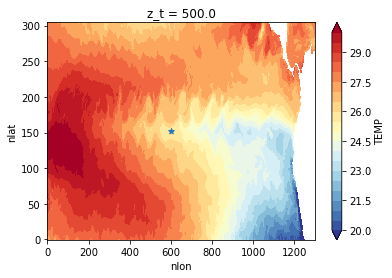

In [5]:
# just making sure everything works
ds.TEMP.isel(z_t=0).mean(dim="time").plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
plt.scatter(lola_inds["i_140_w"], lola_inds["j_0n"], marker="*");

## Set up vertical thickness and volume for scaling

In [6]:
ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds_g.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

100%|██████████| 305/305 [00:01<00:00, 179.47it/s]


## Set up dataset to gather budget terms

In [7]:
budget = xr.Dataset()

### Set grid and data set for xgcm with metrics

In [8]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

#### 0) Tendency

In [9]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP

#### i) Total heat advection
<p style='text-align: justify;'> We use grid.diff and multiply and divide by the volumes ourselves is the way POP outputs the fluxes. It performs a division by the cell area before saving the terms, which would not be accounted for if we used grid.derivative. Note that we also multiply by dsxgcm.VOL.values and then divide by dsxgcm.VOL. This is due to the same issue, there is a mis-alignment in the grid in this output term that xgcm would not like, and we are getting around it this way. This might be specific to POP and it should likely be possible to use grid.derivative for other models. The variables used here are online accumulated transports as output by the model. If you calculate according to udT/dx etc you will have the transport from the mean fields, and miss the eddy contribution below the timescale of your averaging operator (e.g. monthly for monthly output).</p>

In [10]:
budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

#### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [11]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:, 0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

#### iii) Heat flux due to horizontal diffusion

In [12]:
budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"]

#### iv) Solar Penetration

In [13]:
budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

### plot to make sure it closes at (0N, 140W)

In [14]:
subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"], time=0)

CPU times: user 126 ms, sys: 4.58 ms, total: 130 ms
Wall time: 289 ms


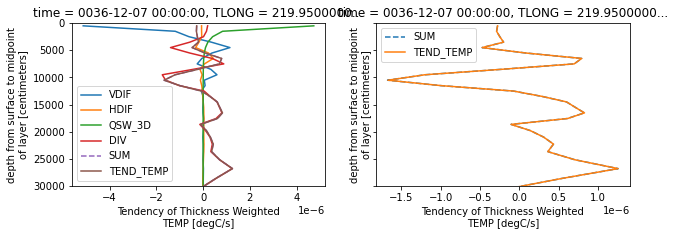

In [15]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(300e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(300e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(300e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(300e2, 0), label="DIV", ax=ax[0])

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[0]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[1]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[1])

ax[1].legend();

In [16]:
# You may need to install watermark (conda install -c conda-forge watermark)
import xgcm  # just to display the version

%load_ext watermark
%watermark -d -iv -m -g
print("Above are the versions of the packages this works with.")

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: c1b73199f169ce40d3a7ded125ec0fbbac90b285

matplotlib: 3.3.4
xarray    : 0.17.0
xgcm      : 0.5.1
numpy     : 1.20.1
pop_tools : 2020.12.15.post10+dirty

Above are the versions of the packages this works with.
